In [1]:
import tensorflow as tf
import os
import numpy as np
import matplotlib.pyplot as plt

2023-04-21 12:32:55.063913: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-04-21 12:32:55.102482: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-21 12:32:55.771848: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
flowers_dir = "/home/walter/git/edgetpu/dataset/flower_photos"
IMAGE_SIZE = 224
BATCH_SIZE = 64

In [3]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255, 
    validation_split=0.2)

train_generator = datagen.flow_from_directory(
    flowers_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE, 
    subset='training')

val_generator = datagen.flow_from_directory(
    flowers_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE, 
    subset='validation')

Found 2939 images belonging to 5 classes.
Found 731 images belonging to 5 classes.


In [4]:
image_batch, label_batch = next(val_generator)
print(image_batch.shape)
print(label_batch.shape)

(64, 224, 224, 3)
(64, 5)


In [5]:
print (train_generator.class_indices)
labels = '\n'.join(sorted(train_generator.class_indices.keys()))
label_file_savepath = os.path.join(flowers_dir, 'flower_labels.txt')
with open(label_file_savepath, 'w') as f:
    f.write(labels)

{'daisy': 0, 'dandelion': 1, 'roses': 2, 'sunflowers': 3, 'tulips': 4}


In [6]:
IMG_SHAPE = (IMAGE_SIZE, IMAGE_SIZE, 3)
base_model = tf.keras.applications.MobileNetV2(
    input_shape=IMG_SHAPE,
    include_top=False, 
    weights='imagenet')
base_model.trainable = False

model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(units=5, activation='softmax')
])

model.compile(
    optimizer='adam', 
    loss='categorical_crossentropy', 
    metrics=['accuracy'])

model.summary()
print('Number of trainable weights = {}'.format(len(model.trainable_weights)))

2023-04-21 12:34:17.162099: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 conv2d (Conv2D)             (None, 5, 5, 32)          368672    
                                                                 
 dropout (Dropout)           (None, 5, 5, 32)          0         
                                                                 
 global_average_pooling2d (G  (None, 32)               0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 5)                 165       
                                                                 
Total params: 2,626,821
Trainable params: 368,837
Non-tr

In [7]:
history = model.fit(train_generator,
                    steps_per_epoch=len(train_generator), 
                    epochs=10,
                    validation_data=val_generator,
                    validation_steps=len(val_generator))

Epoch 1/10


2023-04-21 12:34:28.891093: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


46/46 [==============================] - ETA: 0s - loss: 0.6619 - accuracy: 0.7628

2023-04-21 12:34:40.843248: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


46/46 [==============================] - 15s 282ms/step - loss: 0.6619 - accuracy: 0.7628 - val_loss: 0.4221 - val_accuracy: 0.8509
Epoch 2/10
46/46 [==============================] - 12s 264ms/step - loss: 0.2570 - accuracy: 0.9088 - val_loss: 0.3973 - val_accuracy: 0.8618
Epoch 3/10
46/46 [==============================] - 12s 265ms/step - loss: 0.1666 - accuracy: 0.9459 - val_loss: 0.4930 - val_accuracy: 0.8468
Epoch 4/10
46/46 [==============================] - 12s 266ms/step - loss: 0.1028 - accuracy: 0.9684 - val_loss: 0.4650 - val_accuracy: 0.8659
Epoch 5/10
46/46 [==============================] - 12s 265ms/step - loss: 0.0744 - accuracy: 0.9775 - val_loss: 0.4968 - val_accuracy: 0.8728
Epoch 6/10
46/46 [==============================] - 12s 268ms/step - loss: 0.0442 - accuracy: 0.9878 - val_loss: 0.4950 - val_accuracy: 0.8632
Epoch 7/10
46/46 [==============================] - 12s 265ms/step - loss: 0.0249 - accuracy: 0.9942 - val_loss: 0.4883 - val_accuracy: 0.8769
Epoch 8/10

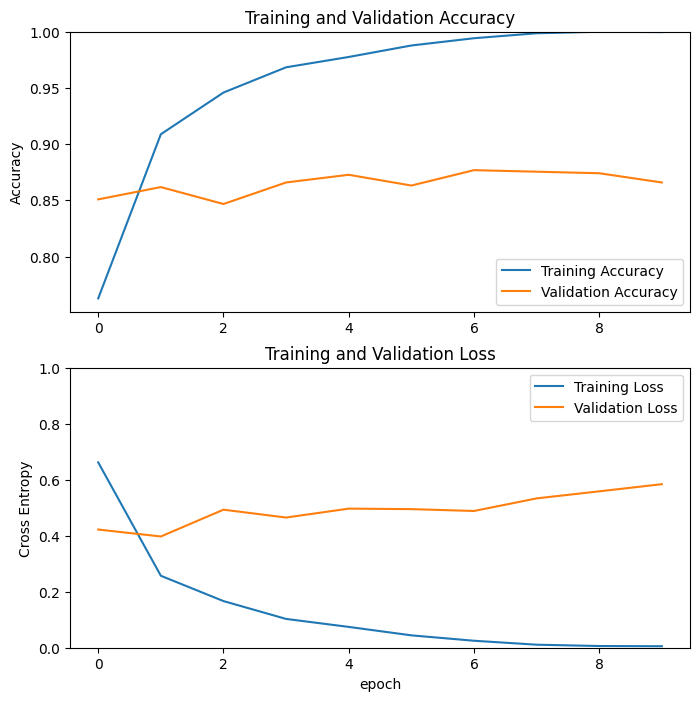

In [8]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [9]:
print("Number of layers in the base model: ", len(base_model.layers))

Number of layers in the base model:  154


In [10]:
base_model.trainable = True
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable =  False

In [11]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy'])
model.summary()
print('Number of trainable weights = {}'.format(len(model.trainable_weights)))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 conv2d (Conv2D)             (None, 5, 5, 32)          368672    
                                                                 
 dropout (Dropout)           (None, 5, 5, 32)          0         
                                                                 
 global_average_pooling2d (G  (None, 32)               0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 5)                 165       
                                                                 
Total params: 2,626,821
Trainable params: 2,230,277
Non-

In [12]:
history_fine = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator), 
    epochs=5,
    validation_data=val_generator,
    validation_steps=len(val_generator))

Epoch 1/5


2023-04-21 12:38:15.659158: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


46/46 [==============================] - ETA: 0s - loss: 0.4661 - accuracy: 0.8585

2023-04-21 12:38:33.201415: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


46/46 [==============================] - 21s 357ms/step - loss: 0.4661 - accuracy: 0.8585 - val_loss: 0.5736 - val_accuracy: 0.8673
Epoch 2/5
46/46 [==============================] - 16s 341ms/step - loss: 0.2215 - accuracy: 0.9234 - val_loss: 0.5821 - val_accuracy: 0.8646
Epoch 3/5
46/46 [==============================] - 16s 340ms/step - loss: 0.1330 - accuracy: 0.9513 - val_loss: 0.5857 - val_accuracy: 0.8700
Epoch 4/5
46/46 [==============================] - 16s 342ms/step - loss: 0.1017 - accuracy: 0.9619 - val_loss: 0.5769 - val_accuracy: 0.8741
Epoch 5/5
46/46 [==============================] - 16s 339ms/step - loss: 0.0754 - accuracy: 0.9738 - val_loss: 0.5732 - val_accuracy: 0.8755


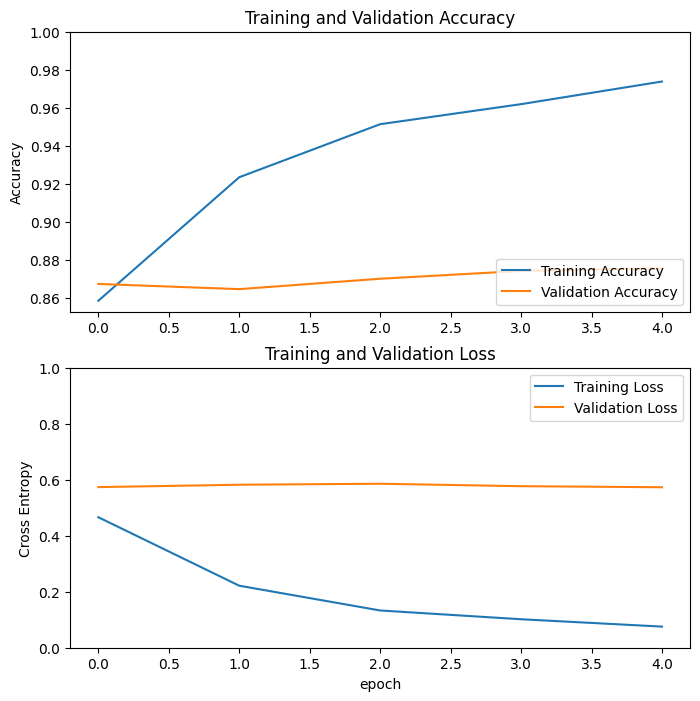

In [13]:
acc = history_fine.history['accuracy']
val_acc = history_fine.history['val_accuracy']

loss = history_fine.history['loss']
val_loss = history_fine.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [14]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

out_dir = "/home/walter/git/edgetpu/post_quantization/out"
save_path = os.path.join(out_dir, 'mobilenet_v2_1.0_224.tflite')
with open(save_path, 'wb') as f:
    f.write(tflite_model)

2023-04-21 12:41:54.210915: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,5,5,32]
	 [[{{node inputs}}]]
2023-04-21 12:41:56.758015: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,5,5,32]
	 [[{{node inputs}}]]


INFO:tensorflow:Assets written to: /tmp/tmpxi1ij3x6/assets


INFO:tensorflow:Assets written to: /tmp/tmpxi1ij3x6/assets
2023-04-21 12:42:09.673252: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:364] Ignored output_format.
2023-04-21 12:42:09.673276: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:367] Ignored drop_control_dependency.
2023-04-21 12:42:09.673619: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpxi1ij3x6
2023-04-21 12:42:09.695030: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2023-04-21 12:42:09.695053: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpxi1ij3x6
2023-04-21 12:42:09.768534: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:353] MLIR V1 optimization pass is not enabled
2023-04-21 12:42:09.794591: I tensorflow/cc/saved_model/loader.cc:231] Restoring SavedModel bundle.
2023-04-21 12:42:10.323758: I tensorflow/cc/saved_model/loader.cc:215] Running initializatio

In [15]:
# A generator that provides a representative dataset
def representative_data_gen():
  dataset_list = tf.data.Dataset.list_files(flowers_dir + '/*/*')
  for i in range(100):
    image = next(iter(dataset_list))
    image = tf.io.read_file(image)
    image = tf.io.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [IMAGE_SIZE, IMAGE_SIZE])
    image = tf.cast(image / 255., tf.float32)
    image = tf.expand_dims(image, 0)
    yield [image]

converter = tf.lite.TFLiteConverter.from_keras_model(model)
# This enables quantization
converter.optimizations = [tf.lite.Optimize.DEFAULT]
# This sets the representative dataset for quantization
converter.representative_dataset = representative_data_gen
# This ensures that if any ops can't be quantized, the converter throws an error
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
# For full integer quantization, though supported types defaults to int8 only, we explicitly declare it for clarity.
converter.target_spec.supported_types = [tf.int8]
# These set the input and output tensors to uint8 (added in r2.3)
converter.inference_input_type = tf.uint8
converter.inference_output_type = tf.uint8
tflite_model = converter.convert()

quant_save_path = os.path.join(out_dir, 'mobilenet_v2_1.0_224_quant.tflite')
with open(quant_save_path, 'wb') as f:
  f.write(tflite_model)

2023-04-21 12:42:55.322911: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,5,5,32]
	 [[{{node inputs}}]]
2023-04-21 12:42:57.539930: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,5,5,32]
	 [[{{node inputs}}]]


INFO:tensorflow:Assets written to: /tmp/tmpxor65is8/assets


INFO:tensorflow:Assets written to: /tmp/tmpxor65is8/assets
/home/walter/git/edgetpu/venv/lib/python3.8/site-packages/tensorflow/lite/python/convert.py:789: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "
2023-04-21 12:43:10.182926: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:364] Ignored output_format.
2023-04-21 12:43:10.182949: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:367] Ignored drop_control_dependency.
2023-04-21 12:43:10.183137: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpxor65is8
2023-04-21 12:43:10.204838: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2023-04-21 12:43:10.204862: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpxor65is8
2023-04-21 12:43:10.306936: I tensorflow/cc/saved_model/